## This is the softmax workbook for ECE C147/C247 Assignment #2

Please follow the notebook linearly to implement a softmax classifier.

Please print out the workbook entirely when completed.

We thank Serena Yeung & Justin Johnson for permission to use code written for the CS 231n class (cs231n.stanford.edu).  These are the functions in the cs231n folders and code in the jupyer notebook to preprocess and show the images.  The classifiers used are based off of code prepared for CS 231n as well.

The goal of this workbook is to give you experience with training a softmax classifier.

In [1]:
import random
import numpy as np
from cs231n.data_utils import load_CIFAR10
import matplotlib.pyplot as plt

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000, num_dev=500):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the linear classifier. These are the same steps as we used for the
    SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = '/Users/victoryang/ece247/HW2/HW2-code/nndl/cifar-10-batches-py' # You need to update this line
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
    
    # subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]
    mask = np.random.choice(num_training, num_dev, replace=False)
    X_dev = X_train[mask]
    y_dev = y_train[mask]
    
    # Preprocessing: reshape the image data into rows
    X_train = np.reshape(X_train, (X_train.shape[0], -1))
    X_val = np.reshape(X_val, (X_val.shape[0], -1))
    X_test = np.reshape(X_test, (X_test.shape[0], -1))
    X_dev = np.reshape(X_dev, (X_dev.shape[0], -1))
    
    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis = 0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image
    X_dev -= mean_image
    
    # add bias dimension and transform into columns
    X_train = np.hstack([X_train, np.ones((X_train.shape[0], 1))])
    X_val = np.hstack([X_val, np.ones((X_val.shape[0], 1))])
    X_test = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
    X_dev = np.hstack([X_dev, np.ones((X_dev.shape[0], 1))])
    
    return X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test, X_dev, y_dev = get_CIFAR10_data()
print('Train data shape: ', X_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', X_val.shape)
print('Validation labels shape: ', y_val.shape)
print('Test data shape: ', X_test.shape)
print('Test labels shape: ', y_test.shape)
print('dev data shape: ', X_dev.shape)
print('dev labels shape: ', y_dev.shape)

Train data shape:  (49000, 3073)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3073)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3073)
Test labels shape:  (1000,)
dev data shape:  (500, 3073)
dev labels shape:  (500,)


## Training a softmax classifier.

The following cells will take you through building a softmax classifier.  You will implement its loss function, then subsequently train it with gradient descent.  Finally, you will choose the learning rate of gradient descent to optimize its classification performance.

In [15]:
from nndl import Softmax

In [16]:
# Declare an instance of the Softmax class.  
# Weights are initialized to a random value.
# Note, to keep people's first solutions consistent, we are going to use a random seed.

np.random.seed(1)

num_classes = len(np.unique(y_train))
num_features = X_train.shape[1]

softmax = Softmax(dims=[num_classes, num_features])

#### Softmax loss

In [17]:
## Implement the loss function of the softmax using a for loop over
#  the number of examples

loss = softmax.loss(X_train, y_train)

In [18]:
print(loss)

2.3277607028048966


## Question: 

You'll notice the loss returned by the softmax is about 2.3 (if implemented correctly).  Why does this make sense?

## Answer:

   Since after normalizing the loss function is equal to -log(0.1), -log(0.1) is approximately equal to 2.3.

#### Softmax gradient

In [19]:
## Calculate the gradient of the softmax loss in the Softmax class.
# For convenience, we'll write one function that computes the loss
#   and gradient together, softmax.loss_and_grad(X, y)
# You may copy and paste your loss code from softmax.loss() here, and then
#   use the appropriate intermediate values to calculate the gradient.

loss, grad = softmax.loss_and_grad(X_dev,y_dev)

# Compare your gradient to a gradient check we wrote. 
# You should see relative gradient errors on the order of 1e-07 or less if you implemented the gradient correctly.
softmax.grad_check_sparse(X_dev, y_dev, grad)

numerical: 0.443528 analytic: 0.443528, relative error: 1.585703e-08
numerical: -0.340457 analytic: -0.340457, relative error: 3.142797e-08
numerical: 0.144475 analytic: 0.144475, relative error: 3.396079e-08
numerical: 1.773308 analytic: 1.773308, relative error: 1.993822e-08
numerical: 1.796912 analytic: 1.796912, relative error: 2.605086e-08
numerical: 0.570833 analytic: 0.570833, relative error: 7.738723e-08
numerical: -0.309554 analytic: -0.309554, relative error: 1.525409e-07
numerical: -1.498445 analytic: -1.498445, relative error: 1.129962e-08
numerical: -0.216903 analytic: -0.216903, relative error: 3.748574e-09
numerical: -4.354321 analytic: -4.354321, relative error: 1.023010e-08


## A vectorized version of Softmax

To speed things up, we will vectorize the loss and gradient calculations.  This will be helpful for stochastic gradient descent.

In [24]:
import time

In [25]:
## Implement softmax.fast_loss_and_grad which calculates the loss and gradient
#    WITHOUT using any for loops.  

# Standard loss and gradient
tic = time.time()
loss, grad = softmax.loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Normal loss / grad_norm: {} / {} computed in {}s'.format(loss, np.linalg.norm(grad, 'fro'), toc - tic))

tic = time.time()
loss_vectorized, grad_vectorized = softmax.fast_loss_and_grad(X_dev, y_dev)
toc = time.time()
print('Vectorized loss / grad: {} / {} computed in {}s'.format(loss_vectorized, np.linalg.norm(grad_vectorized, 'fro'), toc - tic))

# The losses should match but your vectorized implementation should be much faster.
print('difference in loss / grad: {} /{} '.format(loss - loss_vectorized, np.linalg.norm(grad - grad_vectorized)))

# You should notice a speedup with the same output.

Normal loss / grad_norm: 2.294859546499042 / 311.22095449691204 computed in 0.08571529388427734s
Vectorized loss / grad: 2.294859546509597 / 311.2209544969666 computed in 0.004744291305541992s
difference in loss / grad: -1.0555112339716288e-11 /4.633300536137443e-10 


## Stochastic gradient descent

We now implement stochastic gradient descent.  This uses the same principles of gradient descent we discussed in class, however, it calculates the gradient by only using examples from a subset of the training set (so each gradient calculation is faster).

## Question:

How should the softmax gradient descent training step differ from the svm training step, if at all?

## Answer:

The training step in softmax should be smaller than the training step in SVM.

iteration 0 / 1500: loss 2.3527274185372717
iteration 100 / 1500: loss 2.049314011908757
iteration 200 / 1500: loss 1.9887354989013044
iteration 300 / 1500: loss 2.0041970487789396
iteration 400 / 1500: loss 1.956621960007035
iteration 500 / 1500: loss 1.947909809115519
iteration 600 / 1500: loss 1.8864549737505778
iteration 700 / 1500: loss 1.950895872914937
iteration 800 / 1500: loss 1.8269082159369505
iteration 900 / 1500: loss 1.8128166395440792
iteration 1000 / 1500: loss 1.893000700816382
iteration 1100 / 1500: loss 1.8856668782811363
iteration 1200 / 1500: loss 1.876394170600548
iteration 1300 / 1500: loss 1.7617932086272325
iteration 1400 / 1500: loss 1.9655606543780864
That took 1.9159669876098633s


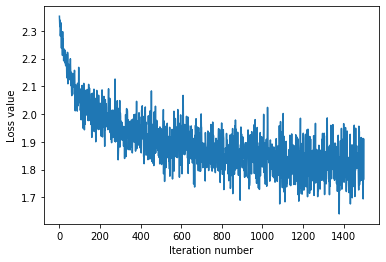

In [40]:
# Implement softmax.train() by filling in the code to extract a batch of data
# and perform the gradient step.
import time


tic = time.time()
loss_hist = softmax.train(X_train, y_train, learning_rate=1e-7,
                      num_iters=1500, verbose=True)
toc = time.time()
print('That took {}s'.format(toc - tic))

plt.plot(loss_hist)
plt.xlabel('Iteration number')
plt.ylabel('Loss value')
plt.show()

### Evaluate the performance of the trained softmax classifier on the validation data.

In [41]:
## Implement softmax.predict() and use it to compute the training and testing error.

y_train_pred = softmax.predict(X_train)
print('training accuracy: {}'.format(np.mean(np.equal(y_train,y_train_pred), )))
y_val_pred = softmax.predict(X_val)
print('validation accuracy: {}'.format(np.mean(np.equal(y_val, y_val_pred)), ))

training accuracy: 0.3807142857142857
validation accuracy: 0.381


## Optimize the softmax classifier

You may copy and paste your optimization code from the SVM here.

In [42]:
np.finfo(float).eps

2.220446049250313e-16

Learning_rate is: 4e-08
iteration 0 / 1500: loss 2.332901521010724
iteration 100 / 1500: loss 2.159942852774085
iteration 200 / 1500: loss 2.117141454495158
iteration 300 / 1500: loss 2.000683615635257
iteration 400 / 1500: loss 2.045190837996928
iteration 500 / 1500: loss 1.9783129679658173
iteration 600 / 1500: loss 1.8708744322316733
iteration 700 / 1500: loss 1.9097040745107097
iteration 800 / 1500: loss 1.950603680984421
iteration 900 / 1500: loss 1.8867566869237344
iteration 1000 / 1500: loss 1.8630154707309157
iteration 1100 / 1500: loss 1.8944687670007954
iteration 1200 / 1500: loss 1.872478120905497
iteration 1300 / 1500: loss 2.0238064580356445
iteration 1400 / 1500: loss 1.8881489338133997


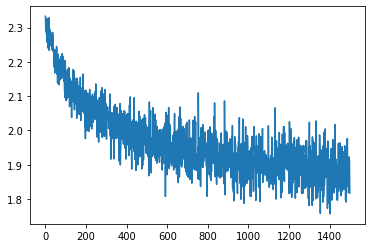

Learning_rate is: 5e-08
iteration 0 / 1500: loss 2.3661211393275825
iteration 100 / 1500: loss 2.161406144701231
iteration 200 / 1500: loss 2.053297494128132
iteration 300 / 1500: loss 1.9918686858174575
iteration 400 / 1500: loss 1.970886315302336
iteration 500 / 1500: loss 1.9237441006235005
iteration 600 / 1500: loss 1.9339952815960582
iteration 700 / 1500: loss 1.8597468184003745
iteration 800 / 1500: loss 1.8759729490949189
iteration 900 / 1500: loss 1.8651213893552085
iteration 1000 / 1500: loss 1.9887392791167275
iteration 1100 / 1500: loss 1.85775869214253
iteration 1200 / 1500: loss 1.8815451523422078
iteration 1300 / 1500: loss 1.9107806168380927
iteration 1400 / 1500: loss 1.9267383478379885


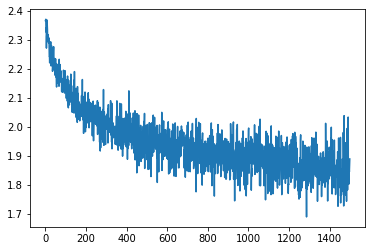

Learning_rate is: 6e-08
iteration 0 / 1500: loss 2.4003470554165727
iteration 100 / 1500: loss 2.203597565951086
iteration 200 / 1500: loss 2.075013054890555
iteration 300 / 1500: loss 1.9757589790814563
iteration 400 / 1500: loss 1.98678107237762
iteration 500 / 1500: loss 1.9095633295221521
iteration 600 / 1500: loss 1.906837493856723
iteration 700 / 1500: loss 1.8639333480566496
iteration 800 / 1500: loss 1.900578108017716
iteration 900 / 1500: loss 1.8699772411475737
iteration 1000 / 1500: loss 1.845652637304713
iteration 1100 / 1500: loss 1.8619169127451414
iteration 1200 / 1500: loss 1.7977109567642275
iteration 1300 / 1500: loss 1.8098215516172849
iteration 1400 / 1500: loss 1.9411574581881215


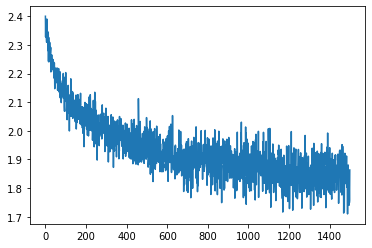

Learning_rate is: 2e-07
iteration 0 / 1500: loss 2.378107905911759
iteration 100 / 1500: loss 2.029457672112883
iteration 200 / 1500: loss 1.8457243091310156
iteration 300 / 1500: loss 1.8767406904517747
iteration 400 / 1500: loss 1.917918270853741
iteration 500 / 1500: loss 1.7540137898296932
iteration 600 / 1500: loss 1.7824258923068894
iteration 700 / 1500: loss 1.8545024584690861
iteration 800 / 1500: loss 1.915618127585822
iteration 900 / 1500: loss 1.7875319197172685
iteration 1000 / 1500: loss 1.7819608084790246
iteration 1100 / 1500: loss 1.7556290586308123
iteration 1200 / 1500: loss 1.724557187781919
iteration 1300 / 1500: loss 1.9130351825695913
iteration 1400 / 1500: loss 1.8379620904834446


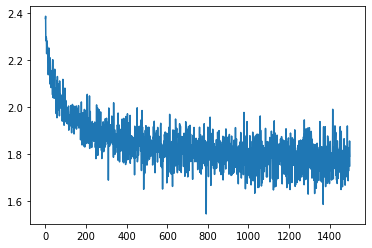

Learning_rate is: 3e-07
iteration 0 / 1500: loss 2.3220229136601285
iteration 100 / 1500: loss 1.9223853053427178
iteration 200 / 1500: loss 1.9341089726528553
iteration 300 / 1500: loss 1.8168766579397186
iteration 400 / 1500: loss 1.837876453221733
iteration 500 / 1500: loss 1.843939622356377
iteration 600 / 1500: loss 1.7214696336212247
iteration 700 / 1500: loss 1.765697484890978
iteration 800 / 1500: loss 1.8622539996542582
iteration 900 / 1500: loss 1.8032993510260231
iteration 1000 / 1500: loss 1.7341374833530312
iteration 1100 / 1500: loss 1.8263166379443105
iteration 1200 / 1500: loss 1.7010848905508495
iteration 1300 / 1500: loss 1.7369450395002182
iteration 1400 / 1500: loss 1.7023799949851102


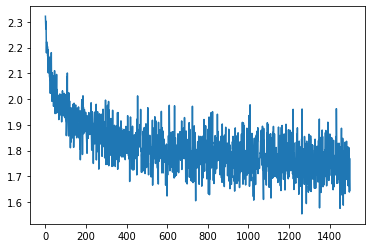

Learning_rate is: 4e-07
iteration 0 / 1500: loss 2.3704011915086336
iteration 100 / 1500: loss 1.8776422570103088
iteration 200 / 1500: loss 1.8536940867027618
iteration 300 / 1500: loss 1.7915901630492561
iteration 400 / 1500: loss 1.8125704910517124
iteration 500 / 1500: loss 1.7722932413974748
iteration 600 / 1500: loss 1.826940541139315
iteration 700 / 1500: loss 1.8500033433469907
iteration 800 / 1500: loss 1.8601610370769712
iteration 900 / 1500: loss 1.8135316539922899
iteration 1000 / 1500: loss 1.8355463993718735
iteration 1100 / 1500: loss 1.7118229498135316
iteration 1200 / 1500: loss 1.677922222283654
iteration 1300 / 1500: loss 1.7530220860045165
iteration 1400 / 1500: loss 1.7673373645189896


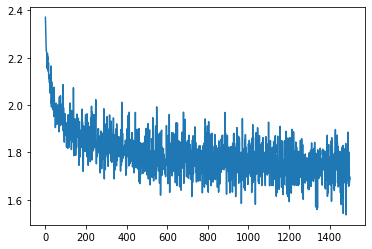

Learning_rate is: 5e-07
iteration 0 / 1500: loss 2.428366259904191
iteration 100 / 1500: loss 1.9599751115234658
iteration 200 / 1500: loss 1.9676433559248172
iteration 300 / 1500: loss 1.7937519566390612
iteration 400 / 1500: loss 1.871749111454875
iteration 500 / 1500: loss 1.7738726852208193
iteration 600 / 1500: loss 1.74447450096227
iteration 700 / 1500: loss 1.7161550027515
iteration 800 / 1500: loss 1.7420605894126846
iteration 900 / 1500: loss 1.7223528542876565
iteration 1000 / 1500: loss 1.788250936403279
iteration 1100 / 1500: loss 1.6405302669306667
iteration 1200 / 1500: loss 1.7820587308901554
iteration 1300 / 1500: loss 1.6957833737051689
iteration 1400 / 1500: loss 1.6204140737281272


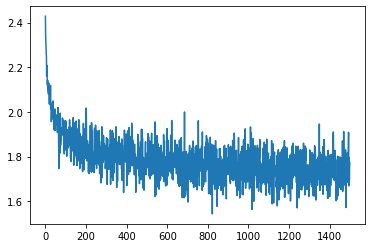

Learning_rate is: 6e-07
iteration 0 / 1500: loss 2.4166791793474522
iteration 100 / 1500: loss 1.911888973094345
iteration 200 / 1500: loss 1.8016796409611697
iteration 300 / 1500: loss 1.7551904251383457
iteration 400 / 1500: loss 1.8623525791088997
iteration 500 / 1500: loss 1.7808709715970639
iteration 600 / 1500: loss 1.7775342580636135
iteration 700 / 1500: loss 1.8438997561879122
iteration 800 / 1500: loss 1.8450737206011238
iteration 900 / 1500: loss 1.7370334609268092
iteration 1000 / 1500: loss 1.7806584346417
iteration 1100 / 1500: loss 1.7204615097915035
iteration 1200 / 1500: loss 1.7163161895534784
iteration 1300 / 1500: loss 1.8203141693385014
iteration 1400 / 1500: loss 1.796063858045655


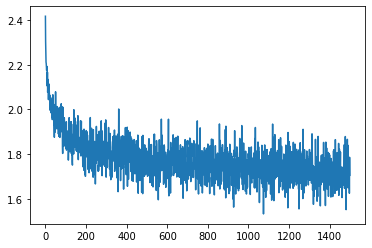

Learning_rate is: 2e-06
iteration 0 / 1500: loss 2.3777508609462723
iteration 100 / 1500: loss 1.7513347514957411
iteration 200 / 1500: loss 1.825479251838284
iteration 300 / 1500: loss 1.7192565125105914
iteration 400 / 1500: loss 1.6766510782366577
iteration 500 / 1500: loss 1.7453746707799251
iteration 600 / 1500: loss 1.732961586403946
iteration 700 / 1500: loss 1.7322873044947962
iteration 800 / 1500: loss 1.6798688756791842
iteration 900 / 1500: loss 1.68046977657674
iteration 1000 / 1500: loss 1.7684490450279906
iteration 1100 / 1500: loss 1.6727400296078532
iteration 1200 / 1500: loss 1.5486985911014353
iteration 1300 / 1500: loss 1.6136089201869503
iteration 1400 / 1500: loss 1.7343691142563022


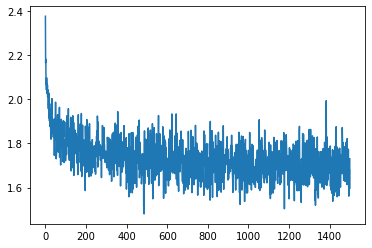

Learning_rate is: 3e-06
iteration 0 / 1500: loss 2.3992135458241277
iteration 100 / 1500: loss 1.9172176874085887
iteration 200 / 1500: loss 1.7910143532069622
iteration 300 / 1500: loss 1.7226973237324836
iteration 400 / 1500: loss 1.6001833189498074
iteration 500 / 1500: loss 1.6261501518977584
iteration 600 / 1500: loss 1.731872657734136
iteration 700 / 1500: loss 1.8377571942147113
iteration 800 / 1500: loss 1.6370612054197764
iteration 900 / 1500: loss 1.756803492727745
iteration 1000 / 1500: loss 1.5900636116082094
iteration 1100 / 1500: loss 1.615134184191844
iteration 1200 / 1500: loss 1.7358712772392622
iteration 1300 / 1500: loss 1.629405407169512
iteration 1400 / 1500: loss 1.7801180164379753


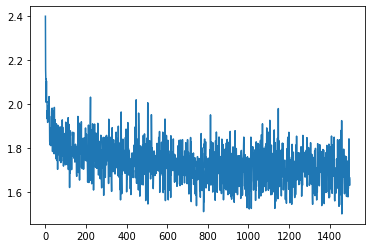

Learning_rate is: 4e-06
iteration 0 / 1500: loss 2.3407545886851406
iteration 100 / 1500: loss 1.757923830504278
iteration 200 / 1500: loss 1.830881228138236
iteration 300 / 1500: loss 1.7965687388095528
iteration 400 / 1500: loss 1.7375389013339104
iteration 500 / 1500: loss 1.7080412304204693
iteration 600 / 1500: loss 1.7517458468766727
iteration 700 / 1500: loss 1.8221057971234333
iteration 800 / 1500: loss 1.7950621754579827
iteration 900 / 1500: loss 1.628579702014197
iteration 1000 / 1500: loss 1.7534917038815485
iteration 1100 / 1500: loss 1.4133057662211126
iteration 1200 / 1500: loss 1.6663690580964359
iteration 1300 / 1500: loss 1.6326842225401779
iteration 1400 / 1500: loss 1.835507458235505


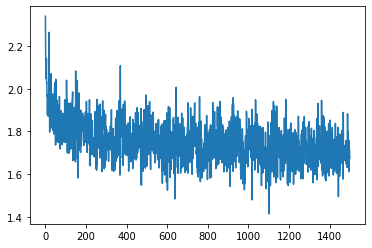

Learning_rate is: 5e-06
iteration 0 / 1500: loss 2.3402894848070033
iteration 100 / 1500: loss 2.076561445603156
iteration 200 / 1500: loss 1.692108730010134
iteration 300 / 1500: loss 1.8392961294722658
iteration 400 / 1500: loss 1.8361121127645261
iteration 500 / 1500: loss 2.0756159207908365
iteration 600 / 1500: loss 1.8187092312584365
iteration 700 / 1500: loss 1.7266890786419173
iteration 800 / 1500: loss 1.762012229683635
iteration 900 / 1500: loss 1.5544664738405567
iteration 1000 / 1500: loss 1.8242833990301603
iteration 1100 / 1500: loss 1.8624065674552148
iteration 1200 / 1500: loss 1.6156167063650329
iteration 1300 / 1500: loss 1.6892906804726693
iteration 1400 / 1500: loss 1.8364032395684466


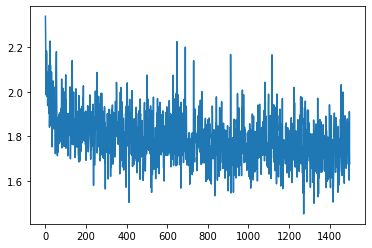

Learning_rate is: 6e-06
iteration 0 / 1500: loss 2.3449333210839445
iteration 100 / 1500: loss 1.7997479524760513
iteration 200 / 1500: loss 2.4847982214373014
iteration 300 / 1500: loss 2.0199973587898965
iteration 400 / 1500: loss 1.7202656323966563
iteration 500 / 1500: loss 1.8192565535017509
iteration 600 / 1500: loss 1.732806725258652
iteration 700 / 1500: loss 1.6246832895489525
iteration 800 / 1500: loss 1.5626376675569227
iteration 900 / 1500: loss 1.8852358041417039
iteration 1000 / 1500: loss 1.9408098391657416
iteration 1100 / 1500: loss 1.8060545190940878
iteration 1200 / 1500: loss 1.75467365181135
iteration 1300 / 1500: loss 1.8471497256723906
iteration 1400 / 1500: loss 1.8066666268681786


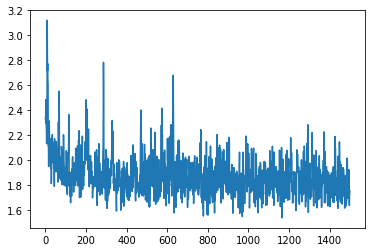

The best learning rate is: 0.000006
The highest accuracy is: 0.410000


In [43]:
# ================================================================ #
# YOUR CODE HERE:
#   Train the Softmax classifier with different learning rates and 
#     evaluate on the validation data.
#   Report:
#     - The best learning rate of the ones you tested.  
#     - The best validation accuracy corresponding to the best validation error.
#
#   Select the SVM that achieved the best validation error and report
#     its error rate on the test set.
# ================================================================ #
learning_rates = [4e-8, 5e-8, 6e-8, 2e-6, 3e-6, 4e-6, 5e-6, 6e-6, 2e-7, 3e-7, 4e-7, 5e-7, 6e-7]
learning_rates_sort = np.sort(learning_rates)
accuracy = []

for lr in learning_rates_sort:
    print('Learning_rate is:', lr)
    loss_best_lr = softmax.train(X_train, y_train, learning_rate = lr,
                      num_iters=1500, verbose=True)
    plt.plot(loss_best_lr)
    plt.show()
    y_pred_best_lr = softmax.predict(X_val)
    accuracy.append(np.mean(np.equal(y_val, y_pred_best_lr)),)

print('The best learning rate is: %f' %learning_rates[np.argmax(accuracy)])
print('The highest accuracy is: %.6f' %np.max(accuracy))
# ================================================================ #
# END YOUR CODE HERE
# ================================================================ #
